# Experiment 5

### Experiment Description

This experiment will be a replica of **Experiment 3** (which has shown the best results so far), but adding the 3 parameters that were generated in **Experiment 4:** “Impact on Volatility,” “News Relevance,” and “News Sentiment Analysis.”

By adding these parameters, it will be evaluated if the neural network performs better in predicting actions to take (buy or sell a stock) and getting the best return on investment. So, the training logic, architecture, and exploration parameters will stay the same — the only change will be the number of inputs, which will now be 20.

#### DQN Implementation

#### Neural Network Architecture

- Input: 20 Nodes (Features)
- Hidden Layer 1: 256 Nodes (ReLU)
- Hidden Layer 2: 128 Nodes (ReLU)
- Hidden Layer 3: 64 Nodes (ReLU)
- Output: 8 Nodes (Actions)

#### Input Modifications

In this section, the 3 parameters obtained in Experiment 4 will be added to include the behavior of international news in the intelligence of the neural network. These will be the following:

- **Volatility:** Volatility that the news from that day will cause in the stock (1 - 3)
- **Relevance:** How relevant the news is to the stock being bought or sold (1 - 10)
- **Sentiment:** How positive or negative the sentiment of the analyzed text was (-1 – 1)

Total 20 Inputs:

- **close_price:** Most recent closing price of Microsoft stock.
- **sma_5:** Average of last 5 closing prices, shows very short-term trend.
- **sma_20:** Average of last 20 closes, shows short to mid-term trend.
- **sma_50:** Average of last 50 closes, shows longer-term market trend.
- **rsi_14:** Relative Strength Index, detects overbought (>70) or oversold (<30) conditions.
- **macd:** Measures momentum by subtracting 26-EMA from 12-EMA.
- **macd_signal:** 9-day EMA of MACD, used to signal buy/sell crossovers.
- **bollinger_b:** Price's position relative to Bollinger Bands; near 1 means close to upper band.
- **atr_14:** Average True Range; shows volatility based on recent high-low price ranges.
- **momentum_10:** Difference between current price and price 10 days ago.
- **cash:** Current uninvested capital available to buy shares.
- **shares_held:** Number of MSFT shares currently owned by the agent.
- **Position/cash ratio:** Invested capital proportion vs. available cash balance.
- **% portfolio invested:** Portfolio allocation percentage per trade position.
- **Relative mean price:** Price average compared to a historical baseline.
- **Normalized volatility:** Volatility scaled to a standard range
- **Scaled RSI (0-1):** Relative Strength Index rescaled for neural network input.
- **Volatility:** Volatility that the news from that day will cause in the stock (1 - 3)
- **Relevance:** How relevant the news is to the stock being bought or sold (1 - 10)
- **Sentiment:** How positive or negative the sentiment of the analyzed text was (-1 – 1)

#### Outputs

- **Buy small:** Buy a small number of shares using a 5% of available cash.
- **Buy small - medium:** Buy more shares using a moderate 10% of cash.
- **Buy large - medium:** Buya litlle more shares using a moderate 20% of cash.
- **Buy large:** Buy many shares using a large 35% of available cash.
- **Sell small:** Sell a small 10% number of shares.
- **Sell small - medium:** Sell more number of shares 25%.
- **Sell large - medium:** Sell a half number of shares (50%).
- **Sell all:** Sell all currently held shares.

#### Reward Mechanism

Differents Rewards Metrics:

- **Basic Profit & Loss:** Returns the portfolio performance for the day (if it increased or decreased).
- **Risk-adjusted Return:** Calculates the Sharpe Ratio using the last 20 returns obtained.
- **Penalty for Invalid Action:** Penalizes if an invalid action was taken (buying without money or selling without having stocks).
- **Optimal Position Management:** Rewards if the value in stocks is between 30% – 70% of the portfolio, penalizes if it goes outside that range.
- **Trend Alignment:** Aligns the actions with the market trend."

Weights assigned:

- **Basic Profit & Loss:** 40%
- **Risk-adjusted Return:** 30%
- **Penalty for Invalid Action:** 15%
- **Optimal Position Management:** 10%
- **Trend Alignment:** 5%

#### Training Parameters

- learning_rate = 3e-4 (More stable)
- minibatch_size = 64   (Better for DL)
- discount_factor = 0.9  (Focus onb short periods)
- replay_buffer_size = int(1e6)  (10x larger)
- interpolation_parameter = 1e-2


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Get stock data of News

In [106]:
news_stocks_df = pd.read_csv('../Data/Preprocessed/New_SPY_Stocks-news.csv')
news_stocks_df = news_stocks_df.drop(['Unnamed: 0'], axis=1)
news_stocks_df.head()

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category,SPY_Relevance,Sentiment
0,1999-07-27,85.632195,0.834853,0.834853,Low,NaN,NaN
1,1999-07-28,85.907906,0.321971,0.321971,Low,NaN,NaN
2,1999-07-29,84.706596,-1.398369,1.398369,Medium,NaN,NaN
3,1999-07-30,83.662720,-1.232344,1.232344,Medium,NaN,NaN
4,1999-08-02,83.859734,0.235486,0.235486,Low,NaN,NaN


##### Get testing period

In [107]:
testing_news_stocks = news_stocks_df.copy()
testing_news_stocks = testing_news_stocks[testing_news_stocks['Date'] >= '2005-01-03']
testing_news_stocks = testing_news_stocks[testing_news_stocks['Date'] <= '2018-12-31']
testing_news_stocks = testing_news_stocks.reset_index(drop=True)

In [108]:
testing_news_stocks.shape

(3523, 7)

In [109]:
testing_news_stocks.head()

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category,SPY_Relevance,Sentiment
0,2005-01-03,82.073990,-0.471653,0.471653,Low,2.416425,0.070219
1,2005-01-04,81.071144,-1.221880,1.221880,Medium,2.529672,0.087087
2,2005-01-05,80.511719,-0.690043,0.690043,Low,2.398044,0.169468
3,2005-01-06,80.921066,0.508432,0.508432,Low,2.558549,0.164279
4,2005-01-07,80.805069,-0.143346,0.143346,Low,2.568435,0.144470


In [110]:
testing_news_stocks.isnull().sum()

Date                   0
Close                  0
Daily_Return           0
Daily_Volatility       0
Volatility_Category    0
SPY_Relevance          0
Sentiment              0
dtype: int64

##### Get training period

In [111]:
training_news_stocks = news_stocks_df.copy()
training_news_stocks = training_news_stocks[training_news_stocks['Date'] >= '2000-01-03']
training_news_stocks = training_news_stocks[training_news_stocks['Date'] <= '2004-12-31']
training_news_stocks = training_news_stocks.reset_index(drop=True)

In [112]:
training_news_stocks.shape

(1256, 7)

In [113]:
training_news_stocks.head()

,Date,Close,Daily_Return,Daily_Volatility,Volatility_Category,SPY_Relevance,Sentiment
0,2000-01-03,92.142548,-0.978677,0.978677,Medium,2.454406,0.263196
1,2000-01-04,88.539215,-3.910607,3.910607,High,2.578125,0.262992
2,2000-01-05,88.697601,0.178888,0.178888,Low,2.689423,0.273089
3,2000-01-06,87.272079,-1.607171,1.607171,Medium,2.641906,0.256221
4,2000-01-07,92.340523,5.807634,5.807634,High,2.609040,0.225330


### Get testing data of Experiment 3

In [114]:
testing_SPY = pd.read_csv('../Data/Train_Test/testing_SPY_e3.csv')
testing_SPY = testing_SPY.drop(['Unnamed: 0'], axis=1)
testing_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI
0,2005-01-03,82.073990,82.529770,81.819365,80.077552,55.102031,0.679712,0.757610,0.586922,0.627123,0.586655,1.003112,0.007641,0.551020
1,2005-01-04,81.071144,82.209119,81.825521,80.209643,38.224783,0.540785,0.714245,0.239910,0.691627,-0.436623,0.990781,0.008531,0.382248
2,2005-01-05,80.511719,81.752016,81.841393,80.332306,32.672397,0.381150,0.647626,0.018346,0.713740,-1.623726,0.983753,0.008865,0.326724
3,2005-01-06,80.921066,81.408170,81.854305,80.440407,38.622213,0.284391,0.574979,0.151279,0.711091,-1.412231,0.988599,0.008787,0.386222
4,2005-01-07,80.805069,81.076598,81.847157,80.528044,42.354400,0.196088,0.499201,0.116829,0.711969,-1.589622,0.987268,0.008811,0.423544


In [115]:
testing_SPY.shape

(3523, 14)

In [116]:
print("Oldst Date: ", testing_SPY['Date'].min())
print("Recent Date: ", testing_SPY['Date'].max())

Oldst Date:  2005-01-03
Recent Date:  2018-12-31


##### Add news data

In [117]:
testing_SPY['Volatility'] = testing_news_stocks['Volatility_Category']
testing_SPY['Relevance'] = testing_news_stocks['SPY_Relevance']
testing_SPY['Sentiment'] = testing_news_stocks['Sentiment']

maping = {'Low': 1, 'Medium': 2, 'High': 3}

testing_SPY['Volatility'] =  testing_SPY['Volatility'].map(maping)

testing_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI,Volatility,Relevance,Sentiment
0,2005-01-03,82.073990,82.529770,81.819365,80.077552,55.102031,0.679712,0.757610,0.586922,0.627123,0.586655,1.003112,0.007641,0.551020,1,2.416425,0.070219
1,2005-01-04,81.071144,82.209119,81.825521,80.209643,38.224783,0.540785,0.714245,0.239910,0.691627,-0.436623,0.990781,0.008531,0.382248,2,2.529672,0.087087
2,2005-01-05,80.511719,81.752016,81.841393,80.332306,32.672397,0.381150,0.647626,0.018346,0.713740,-1.623726,0.983753,0.008865,0.326724,1,2.398044,0.169468
3,2005-01-06,80.921066,81.408170,81.854305,80.440407,38.622213,0.284391,0.574979,0.151279,0.711091,-1.412231,0.988599,0.008787,0.386222,1,2.558549,0.164279
4,2005-01-07,80.805069,81.076598,81.847157,80.528044,42.354400,0.196088,0.499201,0.116829,0.711969,-1.589622,0.987268,0.008811,0.423544,1,2.568435,0.144470


In [118]:
testing_SPY.isnull().sum()

Date              0
Close             0
SMA_5             0
SMA_20            0
SMA_50            0
RSI_14            0
MACD              0
MACD_Signal       0
Bollinger_b       0
ATR_14            0
Momentum_10       0
Relative_price    0
Norm_Volatily     0
Scal_RSI          0
Volatility        0
Relevance         0
Sentiment         0
dtype: int64

### Get training data of Experiment 3

In [119]:
training_SPY = pd.read_csv('../Data/Train_Test/training_SPY_e3.csv')
training_SPY = training_SPY.drop(['Unnamed: 0'], axis=1)
training_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI
0,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256,1.013909,0.013072,0.649056
1,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680,0.975171,0.015619,0.480254
2,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451,0.977351,0.016670,0.464169
3,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476,0.962525,0.018111,0.386390
4,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248,1.016759,0.020285,0.561712


In [120]:
training_SPY.shape

(1256, 14)

In [121]:
print("Oldst Date: ", training_SPY['Date'].min())
print("Recent Date: ", training_SPY['Date'].max())

Oldst Date:  2000-01-03
Recent Date:  2004-12-31


In [122]:
training_SPY['Volatility'] = training_news_stocks['Volatility_Category']
training_SPY['Relevance'] = training_news_stocks['SPY_Relevance']
training_SPY['Sentiment'] = training_news_stocks['Sentiment']

maping = {'Low': 1, 'Medium': 2, 'High': 3}

training_SPY['Volatility'] =  training_SPY['Volatility'].map(maping)
training_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10,Relative_price,Norm_Volatily,Scal_RSI,Volatility,Relevance,Sentiment
0,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256,1.013909,0.013072,0.649056,2,2.454406,0.263196
1,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680,0.975171,0.015619,0.480254,3,2.578125,0.262992
2,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451,0.977351,0.016670,0.464169,1,2.689423,0.273089
3,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476,0.962525,0.018111,0.386390,2,2.641906,0.256221
4,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248,1.016759,0.020285,0.561712,3,2.609040,0.225330


In [123]:
training_SPY = training_SPY.fillna(0)
training_SPY.isnull().sum()

Date              0
Close             0
SMA_5             0
SMA_20            0
SMA_50            0
RSI_14            0
MACD              0
MACD_Signal       0
Bollinger_b       0
ATR_14            0
Momentum_10       0
Relative_price    0
Norm_Volatily     0
Scal_RSI          0
Volatility        0
Relevance         0
Sentiment         0
dtype: int64

### Creating the architecture of the Neural Network

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import math

In [125]:
class DQN(nn.Module):
    def __init__(self, input_dim=20, output_dim=8):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # [batch_size, 256]
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))  # [batch_size, 128]
        x = self.dropout(F.relu(self.fc3(x)))  # [batch_size, 64]
        x = self.fc4(x)  # ¡Esta línea faltaba! [batch_size, 8]
        return x

### Create Custom Trading Environment

In [126]:
#Custom Trading Environment for a single stock
class TradingEnv:
    """
    Initialize the trading environment.
    """
    def __init__(self, df, initial_cash=10_000):
        # Load and sort data
        self.df = df.reset_index(drop=True).copy()
        self.max_steps = len(self.df) - 2  # total steps (days)

        # Initial portfolio settings
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.shares_held = 0.0
        self.current_step = 0
        self.prev_portfolio_value = initial_cash
        self.returns_history = []

        # Track total reward and history
        self.total_reward = 0
        self.history = []

        # Action mapping
        self.action_mapping = {
            0: 0.05,  # buy small
            1: 0.10,  # buy small - medium
            2: 0.20,  # buy large - medium
            3: 0.35,  # buy large
            4: 0.10,  # sell small
            5: 0.25,  # sell small - medium
            6: 0.50,  # sell large - medium
            7: 1.00   # sell all
        }

        # Define input features
        self.feature_cols = [
            'Close',
            'SMA_5', 'SMA_20', 'SMA_50',
            'RSI_14',
            'MACD', 'MACD_Signal',
            'Bollinger_b',
            'ATR_14',
            'Momentum_10',
            'Relative_price', 'Norm_Volatily', 'Scal_RSI',
            'Volatility', 'Relevance', 'Sentiment'
        ]

    """
    Reset the environment to the initial state.
    """
    def reset(self):
        self.cash = self.initial_cash          
        self.shares_held = 0.0                 
        self.current_step = 0                  
        self.prev_portfolio_value = self.initial_cash  
        self.total_reward = 0.0                
        self.history = []
        self.returns_history = []

        return self._get_state()

    """
    Construct the current state vector.
    """
    def _get_state(self):
        row = self.df.loc[self.current_step]

        # Extract the market features
        features = []
        for col in self.feature_cols:
            features.append(row[col])

        # Append portfolio state
        current_price = self.df.loc[self.current_step, 'Close']
        features.append(self.shares_held * current_price / self.cash)  
        features.append(self.shares_held * current_price / self.initial_cash)  
        features.append(self.cash)
        features.append(self.shares_held)

        return np.array(features, dtype=np.float32)

    def step(self, action):
        done = False
        reward = 0.0
        invalid_action_penalty = -.01

        current_price = self.df.loc[self.current_step, 'Close']
        action_type = self.action_mapping[action]

        #Make Step
        if 0 <= action <= 3:  # buy
            percent = self.action_mapping[action]
            if self.cash >= current_price * action_type:
                self._buy(percent)
        elif 4 <= action <= 7:  # sell
            percent = self.action_mapping[action]
            if self.shares_held > 0:
                self._sell(percent)

        #Get portfolio Value
        portfolio_value = self._get_portfolio_value()

        #Calculate Daily Return
        daily_return = (portfolio_value - self.prev_portfolio_value) / (self.prev_portfolio_value + 1e-6)
        self.returns_history.append(daily_return)

        if len(self.returns_history) > 100:
            self.returns_history.pop(0)

        # Calculate reward
        reward += self.calculate_reward(action)
        self.total_reward += reward

        # Advance to next time step
        self.current_step += 1

        #Get new Price of stock
        self.current_price = self.df.loc[self.current_step, 'Close']

        # Update prev_portfolio value
        self.prev_portfolio_value = portfolio_value

        # Log history for debugging/analysis
        self.history.append({
            'step': self.current_step,
            'cash': self.cash,
            'shares_held': self.shares_held,
            'portfolio_value': portfolio_value,
            'action': action,
            'reward': reward
        })

        done = self.current_step >= self.max_steps - 1
        if done:

            next_state = self._get_state()
            return next_state, reward, done, {}


        next_state = self._get_state()
        return next_state, reward, done, {}


    def calculate_reward(self, action):
        # Inicializar componentes
        rewards = {
            'pnl': 0.0,                  
            'risk_adjusted': 0.0,       
            'invalid_action': 0.0,       
            'position_management': 0.0,  
            'trend_alignment': 0.0     
        }

        # 1. PnL Component
        current_value = self._get_portfolio_value()
        pnl = (current_value - self.prev_portfolio_value) / (self.prev_portfolio_value + 1e-6)
        rewards['pnl'] = np.clip(pnl * 5, -2.0, 2.0)  # Escalado y limitado

        # 2. Risk Adjusted (Sharpe-like)
        returns_window = np.array(self.returns_history[-20:])  # Last 20 returns
        if len(returns_window) > 5:
            volatility = np.std(returns_window) + 1e-6
            risk_free = 0.0002  
            sharpe_like = (np.mean(returns_window) - risk_free) / volatility
            rewards['risk_adjusted'] = np.clip(sharpe_like * 2, -1.5, 1.5)

        # 3. Invalid Action
        invalid_penalty = self._get_invalid_action_penalty(action)
        rewards['invalid_action'] = invalid_penalty

        # 4. Position Managment
        rewards['position_management'] = self._calculate_position_score()

        # 5. Trend Aligment
        rewards['trend_alignment'] = self._calculate_trend_alignment()

        # Final Weights
        weights = {
            'pnl': 0.4,
            'risk_adjusted': 0.3,
            'invalid_action': 0.15,
            'position_management': 0.1,
            'trend_alignment': 0.05
        }

        total_reward = sum(rewards[component] * weights[component] for component in rewards)
        return np.clip(total_reward, -3.0, 3.0)  # Limitar para estabilidad


    def _get_invalid_action_penalty(self, action):
        current_price = self.df.loc[self.current_step, 'Close']
        action_type = self.action_mapping[action]

        if (0 <= action <= 3) and (self.cash < current_price * action_type):
            base_penalty = -0.5

            ambition_penalty = -0.3 * action_type  

            return base_penalty + ambition_penalty

        elif (4 <= action <= 7) and (self.shares_held <= 0):
            base_penalty = -0.4

            size_penalty = -0.2 * abs(action_type)

            return base_penalty + size_penalty

        return 0.0 

    def _calculate_position_score(self):
        """Evalúa qué tan óptima es la posición actual"""
        current_price = self.df.loc[self.current_step, 'Close']
        position_ratio = (self.shares_held * current_price) / self._get_portfolio_value()

        optimal_min = 0.3
        optimal_max = 0.7

        if position_ratio < optimal_min:
            return -0.5 * (optimal_min - position_ratio)  
        elif position_ratio > optimal_max:
            return -0.8 * (position_ratio - optimal_max)  
        else:
            return 0.3  

    def _calculate_trend_alignment(self):
        """Recompensa alinear acciones con tendencia del mercado"""
        price_vs_sma = self.df.loc[self.current_step, 'Close'] / self.df.loc[self.current_step, 'SMA_20']
        rsi = self.df.loc[self.current_step, 'RSI_14']

        if price_vs_sma > 1.02 and rsi < 70:  
            return 0.4 if self.shares_held > 0 else -0.3
        elif price_vs_sma < 0.98 and rsi > 30:  
            return 0.3 if self.shares_held == 0 else -0.4
        else:
            return 0.1 if abs(self.shares_held) < 0.1 else 0.0 

    def _get_portfolio_value(self):
        current_price = self.df.loc[self.current_step, 'Close']
        return self.cash + (self.shares_held * current_price)

    """
    Execute a buy order using a percentage of available cash.
    """
    def _buy(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']

        # Capital to use for this transaction
        amount_to_spend = self.cash * percent

        # Number of whole shares we can buy
        shares_to_buy = int(amount_to_spend // current_price)

        if shares_to_buy > 0:
            self.cash -= shares_to_buy * current_price
            self.shares_held += shares_to_buy

    """
    Execute a sell order using a percentage of held shares.
    """
    def _sell(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']

        # Determine how many shares to sell
        shares_to_sell = int(self.shares_held * percent)

        if shares_to_sell > 0:
            self.cash += shares_to_sell * current_price
            self.shares_held -= shares_to_sell


### Initializing the hyperparameters

In [128]:
# Learning rate for optimizer (controls how fast the model learns)
learning_rate = 3e-4
# Number of experiences used for each learning step
minibatch_size = 64
# Discount factor (γ): how much future rewards are valued vs. immediate rewards
discount_factor = 0.9
# Size of the experience replay buffer
replay_buffer_size = int(1e6)
# Soft update rate (τ): how fast target network updates towards the main network
interpolation_parameter = 1e-2

### Implementing Experience Replay

In [129]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)

        states = torch.from_numpy(
            np.vstack([e[0] for e in experiences if e is not None])
        ).float().to(self.device)

        actions = torch.from_numpy(
            np.vstack([e[1] for e in experiences if e is not None])
        ).long().to(self.device)

        rewards = torch.from_numpy(
            np.vstack([e[2] for e in experiences if e is not None])
        ).float().to(self.device)

        next_states = torch.from_numpy(
            np.vstack([e[3] for e in experiences if e is not None])
        ).float().to(self.device)

        dones = torch.from_numpy(
            np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)
        ).float().to(self.device)

        return states, next_states, actions, rewards, dones

    def __len__(self):
        return len(self.memory)

### Create DQN Agent

In [130]:
class Agent:
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = DQN(state_size, action_size).to(self.device)
        self.target_qnetwork = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
          if len(self.memory.memory) > minibatch_size:
            experiences = self.memory.sample(64)
            self.learn(experiences, discount_factor)

    def act(self, state, epsilon = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
          action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
          return np.argmax(action_values.cpu().data.numpy())
        else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
          target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

### Initializing the DQN agent and Envirionment

In [26]:
agent = Agent(20, 8)
env = TradingEnv(training_SPY)

In [ ]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
#epsilon_ending_value  = 0.1
epsilon_decay_value  = 0.995
#epsilon_decay_value  = 0.95
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
total_value_on_100_episodes = deque(maxlen = 100)
max_reward = 0
max_portfolioValue = 10000

for episode in range(1, number_episodes + 1):
    state = env.reset()
    score = 0
    #for t in range(maximum_number_timesteps_per_episode):
    for t in range(env.max_steps):
        action = agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
          break
    scores_on_100_episodes.append(score)
    total_value_on_100_episodes.append(env.prev_portfolio_value)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)

    print('\rEpisode {}  Score: {:.2f} Initial Catch: {:.2f}  Total Catch {:.2f}, Total Holds:{}, Price stock: {:.2f}, Total Value: {:.2f}'.format(episode, score, env.initial_cash, env.cash, env.shares_held, env.current_price, env.prev_portfolio_value), end = "")

    if score >= max_reward:
      torch.save(agent.local_qnetwork.state_dict(), '/content/drive/MyDrive/Thesis AI/Experiments/Models/dqn_MaxReward_trading_Experiment_6.pth')
      max_reward = score
      print('')
      print('Save model with Reward: '+ str(score) + ' and Value:' + str(env.prev_portfolio_value))

    if env.prev_portfolio_value >= max_portfolioValue:
      torch.save(agent.local_qnetwork.state_dict(), '/content/drive/MyDrive/Thesis AI/Experiments/Models/dqn_MaxValue_trading_Experiment_6.pth')
      max_portfolioValue = env.prev_portfolio_value
      print('')
      print('Save model with Value: '+ str(env.prev_portfolio_value) + ' and Reward:' + str(score))

    if episode % 100 == 0:
        print('')
        print('\rEpisode {}  Average Reward: {:.2f} Average Total Value: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), np.mean(total_value_on_100_episodes)))

torch.save(agent.local_qnetwork.state_dict(), '/content/drive/MyDrive/Thesis AI/Experiments/Models/dqn_final_trading_Experiment_6.pth')

Episode 1  Score: -37.44 Initial Catch: 10000.00  Total Catch 11204.88, Total Holds:0.0, Price stock: 82.80, Total Value: 11204.88
Save model with Value: 11204.87756729126 and Reward:-37.444130166146365
Episode 12  Score: -38.31 Initial Catch: 10000.00  Total Catch 9987.70, Total Holds:19.0, Price stock: 82.80, Total Value: 11558.51
Save model with Value: 11558.50894165039 and Reward:-38.31358348418775
Episode 17  Score: -22.43 Initial Catch: 10000.00  Total Catch 4980.63, Total Holds:84.0, Price stock: 82.80, Total Value: 11925.27
Save model with Value: 11925.274814605713 and Reward:-22.42753811787258
Episode 20  Score: -9.36 Initial Catch: 10000.00  Total Catch 6070.47, Total Holds:71.0, Price stock: 82.80, Total Value: 11940.35
Save model with Value: 11940.35005569458 and Reward:-9.35985937636507
Episode 85  Score: 7.13 Initial Catch: 10000.00  Total Catch 10944.42, Total Holds:21.0, Price stock: 82.80, Total Value: 12680.58
Save model with Reward: 7.125075041830109 and Value:12680.

### Test Model

In [131]:
test_env = TradingEnv(testing_SPY)

In [134]:
# Recreate the model architecture
trained_model = DQN(input_dim=20, output_dim=8)  # adjust if your input/output sizes changed

# Load the weights
trained_model.load_state_dict(torch.load('Models/dqn_MaxValue_trading_Experiment_6.pth', map_location=torch.device('cpu')))
trained_model.eval()  # Set to evaluation mode

DQN(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [135]:
state = test_env.reset()
done = False
total_reward = 0
actions = []
stocks_held = []
actual_cash = []
stock_price = []
portfolio_values = []

while not done:

    state_tensor = torch.from_numpy(state).float().unsqueeze(0)

    with torch.no_grad():
        action_values = trained_model(state_tensor)

    action = torch.argmax(action_values).item()
    next_state, reward, done, _ = test_env.step(action)

    total_reward += reward


    actions.append(action)
    stocks_held.append(test_env.shares_held)
    actual_cash.append(test_env.cash)
    stock_price.append(test_env.current_price)
    portfolio_values.append(test_env.prev_portfolio_value)

    state = next_state

print("Total Reward:", total_reward)
print("Final Portfolio Value:", test_env.prev_portfolio_value)

Total Reward: 24.07355528264367
Final Portfolio Value: 17900.323844909668


### Visualize Result

In [137]:
SPY_stocks = pd.read_csv("../data/Preprocessed/SPY_Data.csv")
SPY_stocks = SPY_stocks.drop(['Unnamed: 0'], axis=1)
SPY_stocks.head()

,Date,High,Low,Close
0,1999-07-26,85.789774,84.844432,84.923210
1,1999-07-27,86.469216,85.317081,85.632195
2,1999-07-28,86.538133,85.454929,85.907906
3,1999-07-29,85.238351,84.017284,84.706596
4,1999-07-30,85.297373,83.544552,83.662720


In [138]:
def group_actions(valor):
    valor = valor.lower()
    if "buy" in valor:
        return "buy"
    elif "sell" in valor:
        return "sell"
    elif "hold" in valor:
        return "hold"

In [139]:
test_vis_SPY = SPY_stocks[SPY_stocks['Date'] >= '2005-01-01']
test_vis_SPY = test_vis_SPY[test_vis_SPY['Date'] <= '2019-01-01']
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.index[0])
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.tail(2).index)
test_vis_SPY = test_vis_SPY.drop(['High', 'Low'], axis=1)
test_vis_SPY['v_Close'] = stock_price
test_vis_SPY['Prev_Action'] = actions
test_vis_SPY['Stocks_Held'] = stocks_held
test_vis_SPY['Actual_Cash'] = actual_cash
test_vis_SPY['Portfolio_Values'] = portfolio_values

test_vis_SPY['Prev_Action'] = test_vis_SPY['Prev_Action'].map({
    0: "Buy Small",
    1: "Buy Small - Medium",
    2: "Buy Large - Medium",
    3: "Buy Large",
    4: "Sell Small",
    5: "Sell Small - Medium",
    6: "Sell Large - Medium",
    7: "Sell Large"
})

test_vis_SPY['Stocks_Money'] = test_vis_SPY['Close'] * test_vis_SPY['Stocks_Held']
test_vis_SPY['Color_Action'] = test_vis_SPY['Prev_Action'].apply(group_actions)

test_vis_SPY.head(10)

,Date,Close,v_Close,Prev_Action,Stocks_Held,Actual_Cash,Portfolio_Values,Stocks_Money,Color_Action
1369,2005-01-04,81.071144,81.071144,Buy Large,42.0,6552.892426,10000.000000,3404.988052,buy
1370,2005-01-05,80.511719,80.511719,Buy Large - Medium,58.0,5255.754120,9957.880478,4669.679688,buy
1371,2005-01-06,80.921066,80.921066,Buy Large - Medium,71.0,4209.101776,9925.433807,5745.395706,buy
1372,2005-01-07,80.805069,80.805069,Buy Large - Medium,81.0,3399.891113,9954.497482,6545.210587,buy
1373,2005-01-10,81.187134,81.187134,Sell Small - Medium,61.0,5015.992493,9945.101700,4952.415161,sell
1374,2005-01-11,80.627693,80.627693,Sell Small - Medium,46.0,6233.799500,9968.407654,3708.873886,sell
1375,2005-01-12,80.893738,80.893738,Buy Large - Medium,61.0,5024.384102,9942.673386,4934.518005,buy
1376,2005-01-13,80.245613,80.245613,Buy Large - Medium,73.0,4053.659248,9958.902107,5857.929756,buy
1377,2005-01-14,80.668640,80.668640,Sell Small - Medium,55.0,5498.080284,9911.589005,4436.775208,sell
1378,2005-01-18,81.507767,81.507767,Buy Large - Medium,68.0,4449.387962,9934.855492,5542.528137,buy


In [140]:
normal_final_invest = 10000 * (test_vis_SPY['Close'].iloc[-1] / test_vis_SPY['Close'].iloc[0])

print("Stock Prices First Day:", test_vis_SPY['Close'].iloc[0])
print("Stock Prices Last Day:", test_vis_SPY['Close'].iloc[-1])
print("Final Portfolio Value if you will invest $10,000 normal:", normal_final_invest)
print("Final Portfolio Value if invest $10,000 with Trading Bot:", test_env.prev_portfolio_value)

Stock Prices First Day: 81.0711441040039
Stock Prices Last Day: 224.37730407714844
Final Portfolio Value if you will invest $10,000 normal: 27676.592770086118
Final Portfolio Value if invest $10,000 with Trading Bot: 17900.323844909668


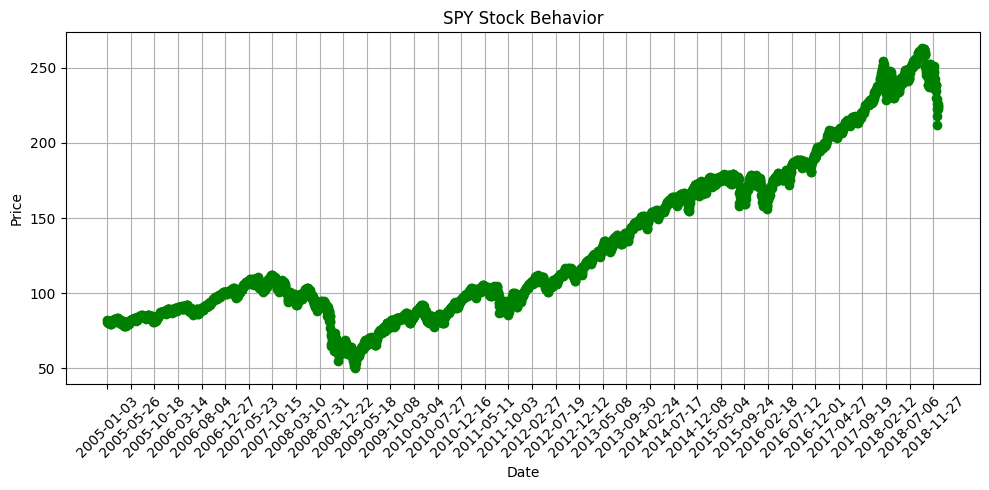

In [141]:
plt.figure(figsize=(10, 5))
plt.plot(testing_SPY['Date'], testing_SPY['Close'], marker='o', linestyle='-', color='green')
plt.title('SPY Stock Behavior')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

skip = 100
plt.xticks(testing_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

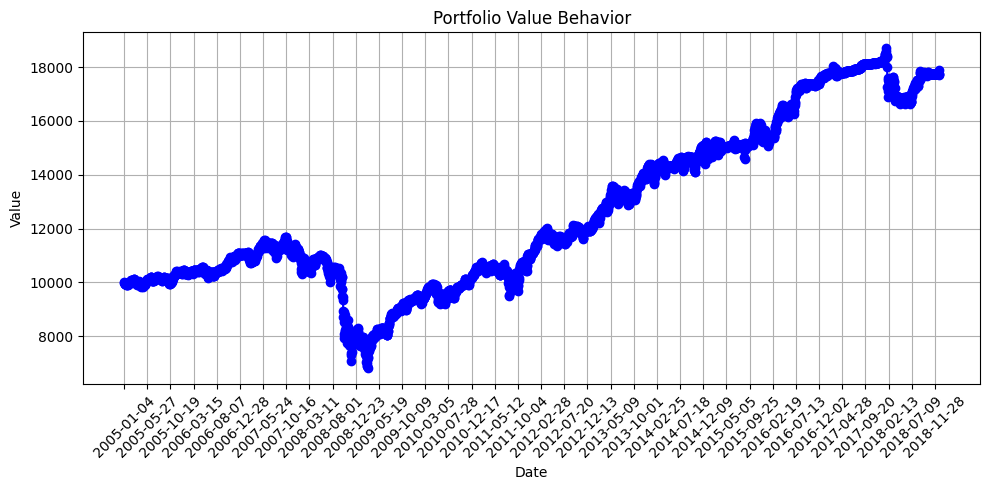

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Portfolio_Values'], marker='o', linestyle='-', color='blue')
plt.title('Portfolio Value Behavior')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

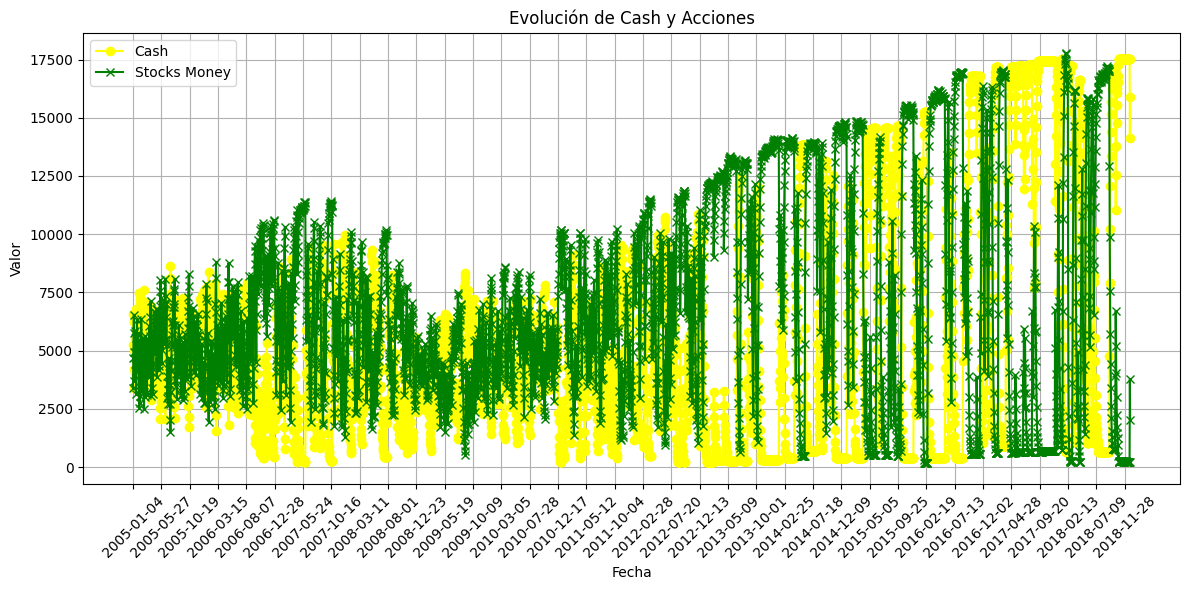

In [143]:
plt.figure(figsize=(12, 6))

plt.plot(test_vis_SPY['Date'], test_vis_SPY['Actual_Cash'], label='Cash', color='Yellow', marker='o')
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Stocks_Money'], label='Stocks Money', color='Green', marker='x')

# Configuración general
plt.title('Evolución de Cash y Acciones')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()

# Mostrar
plt.show()

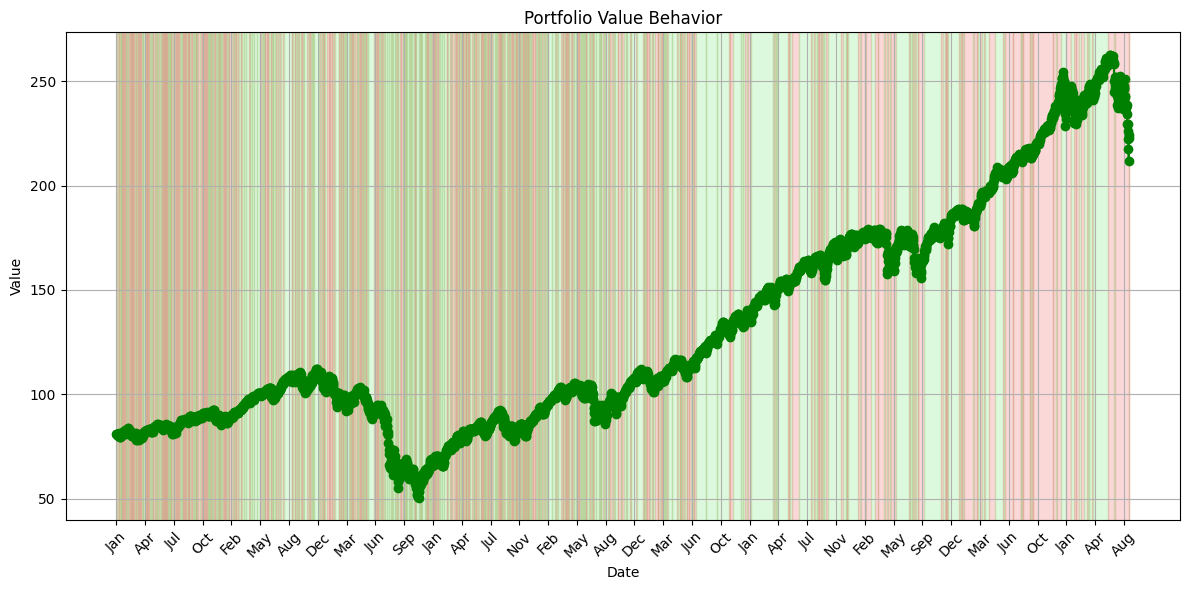

In [144]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_vis_SPY['Date'], test_vis_SPY['Close'], color='green', marker='o')

state_colors = {
    'buy': 'lightgreen',
    'sell': 'lightcoral',
    'hold': 'lightyellow'
}

prev_state = None
start_date = None

for i, row in test_vis_SPY.iterrows():
    current_state = row['Color_Action']
    current_date = row['Date']

    if current_state != prev_state:
        if prev_state is not None:
            ax.axvspan(start_date, current_date, color=state_colors[prev_state], alpha=0.3)
        start_date = current_date
        prev_state = current_state

ax.axvspan(start_date, test_vis_SPY['Date'].iloc[-1], color=state_colors[prev_state], alpha=0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Portfolio Value Behavior")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()